In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv


In [2]:
sns.set(style='dark')
pd.set_option('display.max_columns', 100)
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV,cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor,Pool
from lightgbm import LGBMRegressor



In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
describe = open("data_description.txt","r")
sam = pd.read_csv("sample_submission.csv")
print(describe.read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [4]:
n = pd.DataFrame(train.isna().sum())
m = n.loc[n[0]!=0]
m['% Missing'] = m[0]*100.00/1460.00
m

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,0,% Missing
LotFrontage,259,17.739726
Alley,1369,93.767123
MasVnrType,8,0.547945
MasVnrArea,8,0.547945
BsmtQual,37,2.534247
BsmtCond,37,2.534247
BsmtExposure,38,2.602740
BsmtFinType1,37,2.534247
BsmtFinType2,38,2.602740
Electrical,1,0.068493


In [5]:
n = pd.DataFrame(test.isna().sum())
m = n.loc[n[0]!=0]
m['% Missing'] = m[0]*100.00/1460.00
m.sort_values(by='% Missing',ascending=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,0,% Missing
PoolQC,1456,99.726027
MiscFeature,1408,96.438356
Alley,1352,92.602740
Fence,1169,80.068493
FireplaceQu,730,50.000000
LotFrontage,227,15.547945
GarageCond,78,5.342466
GarageYrBlt,78,5.342466
GarageQual,78,5.342466
GarageFinish,78,5.342466


# **Feature Engineering**

## **MSSublClass**

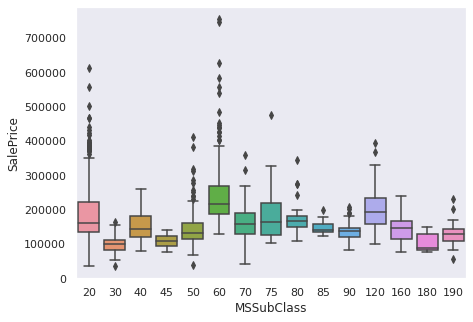

In [6]:
plt.figure(figsize=(7,5))
sns.boxplot(x = 'MSSubClass',y  = 'SalePrice',data = train)

In [7]:
a = pd.DataFrame(train.groupby('MSSubClass')['SalePrice'].mean()).sort_values(by='SalePrice',ascending=False)
b = np.array(a.index)
c = np.arange(len(a),0,-1)
for i in range(len(c)):
    train.loc[train['MSSubClass']==b[i],'MSSubClass']=c[i]
for j in range(len(c)):
    test.loc[test['MSSubClass']==b[j],'MSSubClass']=c[j]
    test.loc[test['MSSubClass']==150,'MSSubClass']= 1


# **MSZone**

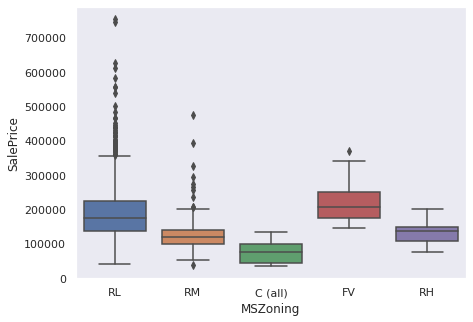

In [8]:
plt.figure(figsize=(7,5))
sns.boxplot(x = 'MSZoning',y  = 'SalePrice',data = train)

In [9]:
a = pd.DataFrame(train.groupby('MSZoning')['SalePrice'].mean()).sort_values('SalePrice')
b = np.array(a.index)
c = np.arange(1,len(a)+1)
for i in range(len(c)):
    train.loc[train['MSZoning']==b[i],'MSZoning']=c[i]
    
test['MSZoning']=test['MSZoning'].fillna('RL')
for i in range(len(c)):
    test.loc[test['MSZoning']==b[i],'MSZoning']=c[i]    

# **LotFrontage**

LotFrontage has 259 missing values. Imputing it with mean values

In [10]:
a = train.loc[train['LotFrontage'].isna()==False,'LotFrontage'].mean()
train['LotFrontage'] = train['LotFrontage'].fillna(a)
test['LotFrontage'] = test['LotFrontage'].fillna(train['LotFrontage'].mean())

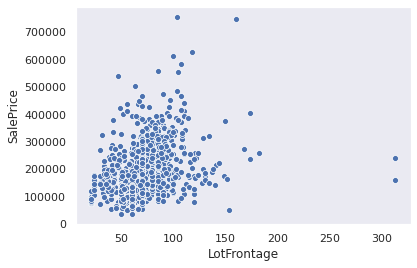

In [11]:
sns.scatterplot(x ='LotFrontage',y= 'SalePrice',data=train)

## **Street**

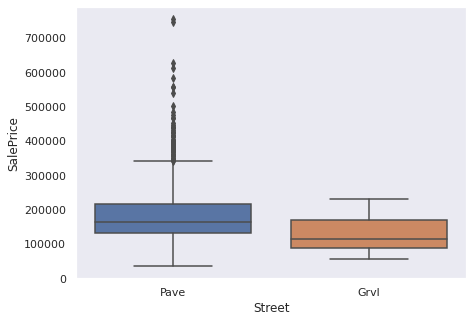

In [12]:
plt.figure(figsize=(7,5))
sns.boxplot(x = 'Street',y  = 'SalePrice',data = train)

In [13]:
a = pd.DataFrame(train.groupby('Street')['SalePrice'].mean()).sort_values('SalePrice')
b = np.array(a.index)
c = np.arange(1,len(a)+1)
for i in range(len(c)):
    train.loc[train['Street']==b[i],'Street']=c[i]
for i in range(len(c)):
    test.loc[test['Street']==b[i],'Street']=c[i]    

## **Alley**

Alley has 94% missing values. So removing it.

In [14]:
train = train.drop(['Alley'],axis=1)
test=  test.drop(['Alley'],axis=1)

## **LotShape**

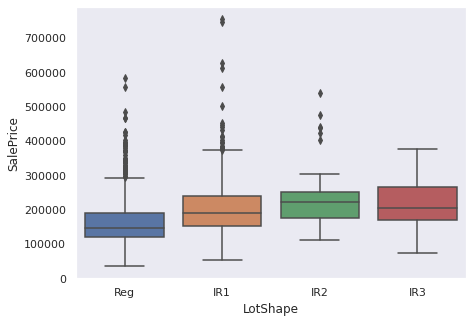

In [15]:
plt.figure(figsize=(7,5))
sns.boxplot(x = 'LotShape',y  = 'SalePrice',data = train)
plt.show()

a = pd.DataFrame(train.groupby('LotShape')['SalePrice'].mean()).sort_values('SalePrice')
b = np.array(a.index)
c = np.arange(1,len(a)+1)
for i in range(len(c)):
    train.loc[train['LotShape']==b[i],'LotShape']=c[i]
for i in range(len(c)):
    test.loc[test['LotShape']==b[i],'LotShape']=c[i]    

### Alley,FireplaceQu,Fence,PoolQC,MiscFeature have lot of missing values.Removing those features

In [16]:
train = train.drop(['FireplaceQu','Fence','PoolQC','MiscFeature'],axis=1)
test = test.drop(['FireplaceQu','Fence','PoolQC','MiscFeature'],axis=1)


# **Other columns with Random Categorical Values**

LandContour,Utilities,LotConfig,LandSlope,Neighbourhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2md,Foundation,Heating,HeatingQC,CentralAir,,Functional,PavedDrive,SaleType all have categorical data without any missing values.

'MasVnrType','GarageType','GarageFinish','Electrical','BsmtFinType1','BsmtFinType2' have some missing values.

Label Encoding the data based on mean of SalePrice:

In [17]:
b = ['MasVnrType','GarageType','GarageFinish','Electrical','BsmtFinType1','BsmtFinType2']

#MasVnrType we'll change all Nan values to None
train['MasVnrType'] = train['MasVnrType'].fillna('None')
test['MasVnrType'] = test['MasVnrType'].fillna('None')

#GarageType Nan values become None meaning no garages. Same for Garage Finish
train['GarageType'] = train['GarageType'].fillna('None')
train['GarageFinish'] = train['GarageFinish'].fillna('None')
test['GarageType'] = test['GarageType'].fillna('None')
test['GarageFinish'] = test['GarageFinish'].fillna('None')


train['Electrical'] = train['Electrical'].fillna('SBrkr')
train['BsmtFinType1'] = train['BsmtFinType1'].fillna('None')
train['BsmtFinType2'] = train['BsmtFinType2'].fillna('None')
test['BsmtFinType1'] = test['BsmtFinType1'].fillna('None')
test['BsmtFinType2'] = test['BsmtFinType2'].fillna('None')
test['Exterior1st'] = test['Exterior1st'].fillna('VinylSd')
test['Exterior2nd'] = test['Exterior2nd'].fillna('VinylSd')
test['SaleType'] = test['SaleType'].fillna('WD')
test['Functional'] = test['Functional'].fillna('Typ')
test['Utilities'] = test['Utilities'].fillna('AllPub')


In [18]:
l = ['LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1','Condition2',
     'BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','Foundation','Heating',
     'HeatingQC','CentralAir','Functional','PavedDrive','SaleType','MasVnrType','GarageType','GarageFinish','Electrical','BsmtFinType1','BsmtFinType2','SaleCondition']

for i in enumerate(l):
    a = pd.DataFrame(train.groupby(i[1])['SalePrice'].mean()).sort_values('SalePrice')
    b = np.array(a.index)
    c = np.arange(1,len(a)+1)
    for j in range(len(c)):
        train.loc[train[i[1]]==b[j],i[1]]=c[j]
    for j in range(len(c)):
        test.loc[test[i[1]]==b[j],i[1]]=c[j]    
        
        

## **Columns with Categorical Values which can be numbered**

In [19]:
b = ['ExterQual','ExterCond','GarageQual','GarageCond','KitchenQual','BsmtCond','BsmtExposure','BsmtQual']

train['GarageQual'] = train['GarageQual'].fillna('Po')
train['GarageCond'] = train['GarageCond'].fillna('Po')
train['BsmtCond'] = train['BsmtCond'].fillna('Fa')
train['BsmtExposure'] = train['BsmtExposure'].fillna('No')
train['BsmtQual'] = train['BsmtQual'].fillna('Fa')
test['GarageQual'] = test['GarageQual'].fillna('Po')
test['GarageCond'] = test['GarageCond'].fillna('Po')
test['BsmtCond'] = test['BsmtCond'].fillna('Fa')
test['BsmtExposure'] = test['BsmtExposure'].fillna('No')
test['BsmtQual'] = test['BsmtQual'].fillna('Fa')
test['KitchenQual'] = test['KitchenQual'].fillna('TA')



for i in enumerate(['ExterQual','KitchenQual','BsmtQual']):
                   train.loc[train[i[1]]=='Fa',i[1]] = 1
                   train.loc[train[i[1]]=='TA',i[1]] = 2
                   train.loc[train[i[1]]=='Gd',i[1]] = 3
                   train.loc[train[i[1]]=='Ex',i[1]] = 4
                   test.loc[test[i[1]]=='Fa',i[1]] = 1
                   test.loc[test[i[1]]=='TA',i[1]] = 2
                   test.loc[test[i[1]]=='Gd',i[1]] = 3
                   test.loc[test[i[1]]=='Ex',i[1]] = 4 
for i in enumerate(['ExterCond','GarageQual','GarageCond','BsmtCond']):
                   train.loc[train[i[1]]=='Po',i[1]] = 1
                   train.loc[train[i[1]]=='Fa',i[1]] = 2
                   train.loc[train[i[1]]=='TA',i[1]] = 3
                   train.loc[train[i[1]]=='Gd',i[1]] = 4
                   train.loc[train[i[1]]=='Ex',i[1]] = 5
                   test.loc[test[i[1]]=='Po',i[1]] = 1
                   test.loc[test[i[1]]=='Fa',i[1]] = 2
                   test.loc[test[i[1]]=='TA',i[1]] = 3
                   test.loc[test[i[1]]=='Gd',i[1]] = 4
                   test.loc[test[i[1]]=='Ex',i[1]] = 5 
                   
for i in enumerate(['BsmtExposure']):
                   train.loc[train[i[1]]=='No',i[1]] = 1
                   train.loc[train[i[1]]=='Mn',i[1]] = 2
                   train.loc[train[i[1]]=='Av',i[1]] = 3
                   train.loc[train[i[1]]=='Gd',i[1]] = 4
                   test.loc[test[i[1]]=='No',i[1]] = 1
                   test.loc[test[i[1]]=='Mn',i[1]] = 2
                   test.loc[test[i[1]]=='Av',i[1]] = 3
                   test.loc[test[i[1]]=='Gd',i[1]] = 4 

In [20]:
train['MasVnrArea'] = train['MasVnrArea'].fillna(train['MasVnrArea'].mean())
test['MasVnrArea'] = test['MasVnrArea'].fillna(test['MasVnrArea'].mean())

train.loc[train['GarageYrBlt'].isna()==True,'GarageYrBlt'] = np.array(train.loc[train['GarageYrBlt'].isna()==True,'YearBuilt'])
test.loc[test['GarageYrBlt'].isna()==True,'GarageYrBlt'] = np.array(test.loc[test['GarageYrBlt'].isna()==True,'YearBuilt'])


In [21]:
test['BsmtFullBath'] = test['BsmtFullBath'].fillna(0.0)
test['BsmtFinSF1'] = test['BsmtFinSF1'].fillna(0.0)
test['BsmtUnfSF'] = test['BsmtUnfSF'].fillna(0.0)
test['TotalBsmtSF'] = test['TotalBsmtSF'].fillna(test['TotalBsmtSF'].mean())
test['GarageCars'] = test['GarageCars'].fillna(2.0)



In [22]:
train = train.drop(['Id','MiscVal','PoolArea','ScreenPorch','3SsnPorch','EnclosedPorch','LowQualFinSF'],axis=1)
test = test.drop(['Id','MiscVal','PoolArea','ScreenPorch','3SsnPorch','EnclosedPorch','LowQualFinSF'],axis=1)

In [23]:
train = train.apply(pd.to_numeric)
test = test.apply(pd.to_numeric)

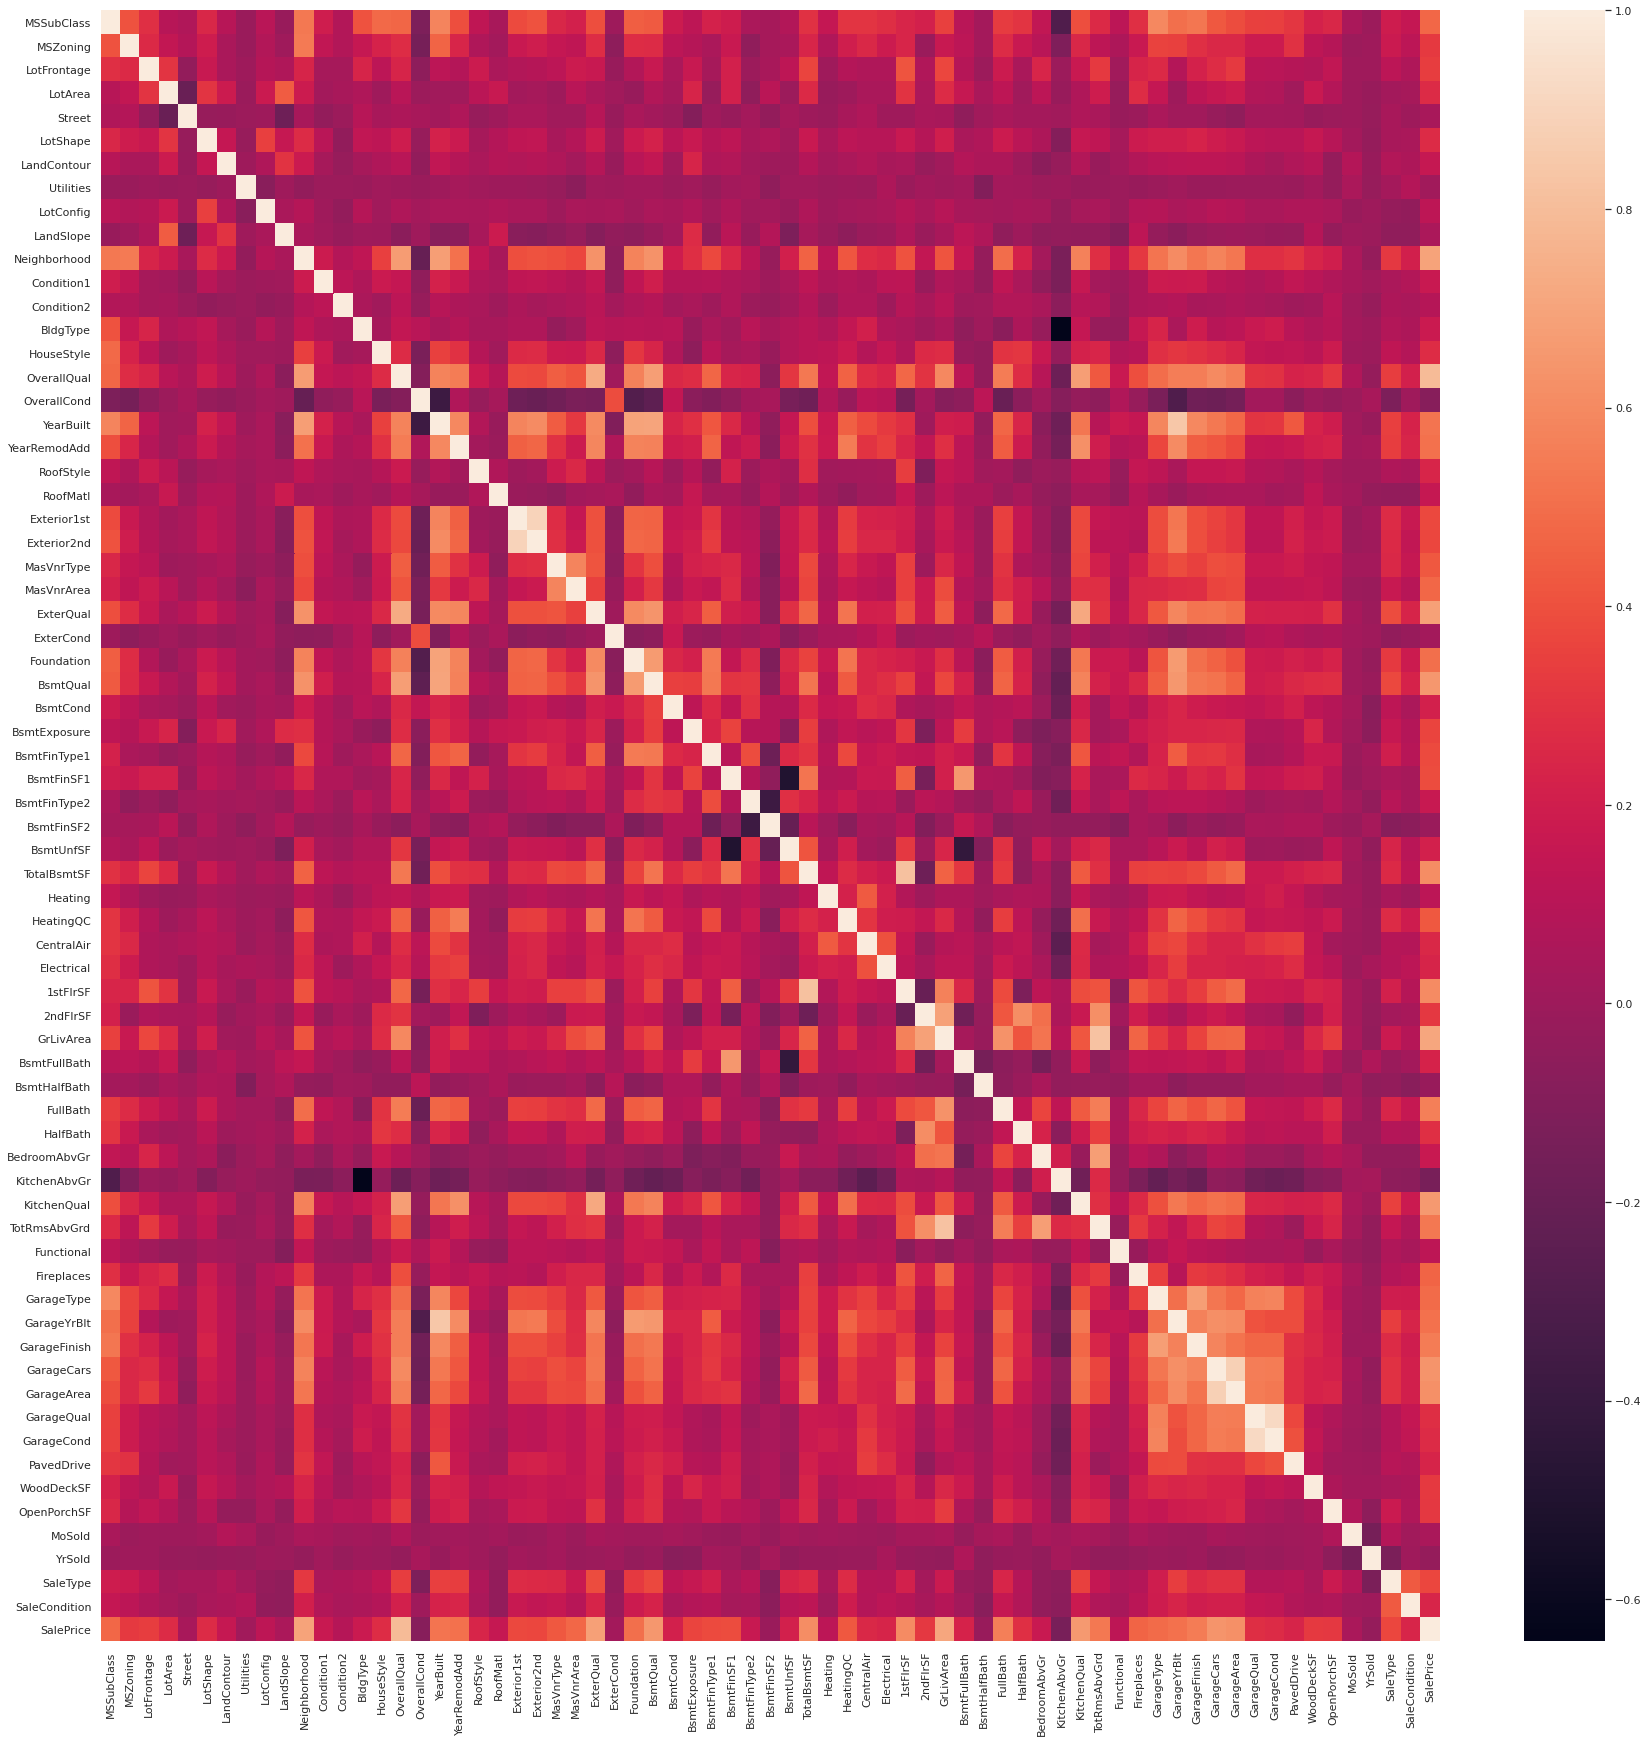

In [24]:
fig = plt.figure(figsize = (30,30))
sns.heatmap(train.corr())

In [25]:
a = pd.DataFrame(train.corr())
b = np.array(a.columns)
value=0.75
c=[]
for i in enumerate(b):
    for j in enumerate(b):
        if i<j:
            if a.loc[i[1],j[1]]>value:
                print(i[1] + ' and ' + j[1] + ' : '+ str(a.loc[i[1],j[1]]))

OverallQual and SalePrice : 0.7909816005838047
YearBuilt and GarageYrBlt : 0.8451406660104657
Exterior1st and Exterior2nd : 0.8914286477600583
TotalBsmtSF and 1stFlrSF : 0.8195299750050355
GrLivArea and TotRmsAbvGrd : 0.8254893743088377
GarageCars and GarageArea : 0.8824754142814603
GarageQual and GarageCond : 0.9185481833548472


## **Observations from Correlation Heatmap**

1. YearBuilt and GarageYrBlt are highly correlated
2. Exterior1st and Exterior2nd are highly correlated
3. TotalBsmtSF and 1stFlrSF are highly correlated
4. GrLivArea and TotRmsAbvGrd are highly correlated
5. GarageCars and GarageArea are highlt correlated
6. GarageQual and GarageCond are highly correlated.

Based on these observations we can drop  GarageYrBlt, Exterior2nd, 1stFlrSF, TotRmsAbvGrd, GarageArea, GarageCond

Also based on correlation matrix we can say that Utilities,LandSlope,Condition2,ExterCond,BsmtFinSF2,BsmtHalfBath have a lot of random values wrt Sale Price.

So we have to drop all these columns.

In [26]:
train  = train.drop(['GarageYrBlt','Exterior2nd','1stFlrSF','TotRmsAbvGrd','GarageArea','GarageCond','Utilities','LandSlope','Condition2','ExterCond','BsmtFinSF2','BsmtHalfBath'],axis=1)
test  = test.drop(['GarageYrBlt','Exterior2nd','1stFlrSF','TotRmsAbvGrd','GarageArea','GarageCond','Utilities','LandSlope','Condition2','ExterCond','BsmtFinSF2','BsmtHalfBath'],axis=1)

In [27]:
x = train.drop(['SalePrice'],axis=1)
y = train['SalePrice']


In [28]:

a = ['LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1','BsmtUnfSF','TotalBsmtSF','2ndFlrSF','GrLivArea','WoodDeckSF','YrSold']

ct = ColumnTransformer([('name',StandardScaler(),a)],remainder='passthrough')

x_norm = pd.DataFrame(ct.fit_transform(x))
test_norm = pd.DataFrame(ct.transform(test))

In [29]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)
x1_train,x1_test,y1_train,y1_test = train_test_split(x_norm,y,test_size=0.2,random_state=42)

In [30]:
test_Id = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")['Id']


## **XGBRegressor**

In [31]:
#XGBoost
model = XGBRegressor(random_state=42,booster='gbtree',eta=0,max_depth=3,learning_rate=0.09,n_estimators=600,reg_alpha=0.01,reg_lambda = 0.1)
model.fit(x_train,y_train)

a = model.predict(test)

## **CatBoostRegressor**

In [32]:
model = CatBoostRegressor(random_state=42,iterations=10000,l2_leaf_reg=50,rsm=0.99,depth=5,random_strength =0.1)
eval_pool = Pool(x_test,y_test)
model.fit(x_train, y_train, eval_set=eval_pool, early_stopping_rounds=10)

b= model.predict(test)


0:	learn: 76096.0247268	test: 86390.2133063	best: 86390.2133063 (0)	total: 56ms	remaining: 9m 20s
1:	learn: 75041.3129941	test: 85258.7401047	best: 85258.7401047 (1)	total: 61.6ms	remaining: 5m 7s
2:	learn: 74044.8427633	test: 84223.9417016	best: 84223.9417016 (2)	total: 68.5ms	remaining: 3m 48s
3:	learn: 73019.5192629	test: 83155.0206792	best: 83155.0206792 (3)	total: 75.2ms	remaining: 3m 7s
4:	learn: 72059.7745523	test: 82160.4053913	best: 82160.4053913 (4)	total: 81.4ms	remaining: 2m 42s
5:	learn: 71072.5208580	test: 81130.8733606	best: 81130.8733606 (5)	total: 87.6ms	remaining: 2m 25s
6:	learn: 70161.3740641	test: 80149.5776854	best: 80149.5776854 (6)	total: 93.8ms	remaining: 2m 13s
7:	learn: 69221.6435400	test: 79165.5535872	best: 79165.5535872 (7)	total: 100ms	remaining: 2m 4s
8:	learn: 68302.5790311	test: 78202.3765672	best: 78202.3765672 (8)	total: 106ms	remaining: 1m 58s
9:	learn: 67456.0243452	test: 77336.2760552	best: 77336.2760552 (9)	total: 112ms	remaining: 1m 52s
10:	lear

## **LGBMRegressor**

In [33]:
model = LGBMRegressor(random_state=42,objective='regression',learning_rate=0.1,n_estimators=443,num_leaves=32,min_child_samples=5,verbose=5,reg_alpha=0.01,reg_lambda=0.001)

model.fit(x_train,y_train)

c = model.predict(test)

In [34]:
sub = (a+b+c)/3
my_submission = pd.DataFrame({'Id': test_Id, 'SalePrice': sub})
my_submission.to_csv('mean_submission.csv', index=False)